In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from tensorflow.keras.utils import to_categorical
import zipfile


# Load the dataset from kaggle

In [ ]:
# Download Dataset from Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kavyasreeb/hair-type-dataset

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset
License(s): apache-2.0
hair-type-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extract Dataset
with zipfile.ZipFile("hair-type-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("HairDataset")



In [ ]:
# Define dataset path
dataset_path = "/content/HairDataset/data"

# EDA

In [ ]:
# Define image properties
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset structure
classes = os.listdir(dataset_path)
classes = [cls for cls in classes if os.path.isdir(os.path.join(dataset_path, cls))]

# Create dataset lists
image_paths = []
labels = []
import imghdr  # To check valid image types

valid_formats = {'jpeg', 'png', 'jpg', 'bmp'}  # Supported formats

for idx, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Check if it's a valid image
        if imghdr.what(img_path) in valid_formats:
            image_paths.append(img_path)
            labels.append(idx)
        else:
            print(f"Skipping invalid file: {img_path}")


# Convert to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split dataset into training and validation sets (80-20 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

Skipping invalid file: /content/HairDataset/data/Straight/Straight-Layered-Hairstyles-1.jpg.webp
Skipping invalid file: /content/HairDataset/data/Straight/hairstyles-for-men-with-straight-hair-4.jpg
Skipping invalid file: /content/HairDataset/data/Straight/long-straight-weave-hairstyle-1.jpg.webp
Skipping invalid file: /content/HairDataset/data/Straight/man-with-long-straight-hair.jpg.webp
Skipping invalid file: /content/HairDataset/data/curly/Untitled-8.jpg
Skipping invalid file: /content/HairDataset/data/curly/rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif
Skipping invalid file: /content/HairDataset/data/curly/blonde-girl-voluminous-curly-hair-600w-1432618526.jpg
Skipping invalid file: /content/HairDataset/data/curly/indian-baby-girl-curly-hair-600w-1664313094.jpg
Skipping invalid file: /content/HairDataset/data/curly/photo.jpg
Skipping invalid file: /content/HairDataset/data/curly/GettyImages-646055712_trans_NvBQzQNjv4BqDo1PhbPPiB1HBZscUHLBE78-ICSbD7

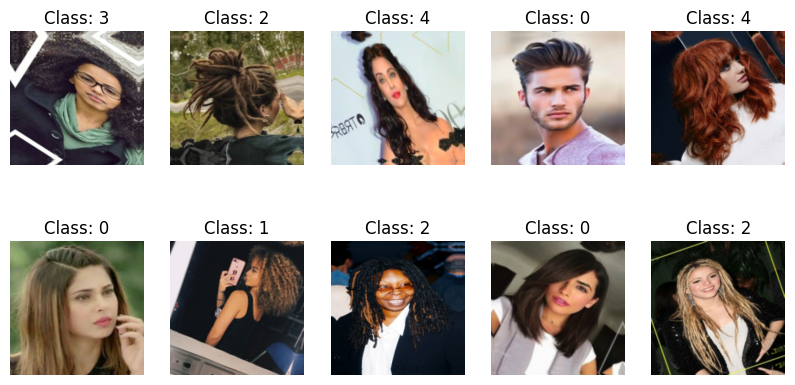

In [ ]:
# Image preprocessing function
def load_and_preprocess_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode image
        image = tf.image.resize(image, IMG_SIZE) / 255.0  # Resize and normalize
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return tf.zeros((IMG_SIZE[0], IMG_SIZE[1], 3))  # Return a blank image instead


# Create TensorFlow dataset
def create_tf_dataset(image_paths, labels, batch_size=BATCH_SIZE, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def process_path(image_path, label):
        image = load_and_preprocess_image(image_path)
        return image, label

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    dataset = dataset.shuffle(len(image_paths)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Prepare training and validation datasets
train_dataset = create_tf_dataset(train_paths, train_labels, augment=True)
val_dataset = create_tf_dataset(val_paths, val_labels, augment=False)

# Display sample images
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_best_cnn(input_shape=(224, 224, 3), num_classes=5):
    inputs = layers.Input(shape=input_shape)


    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0001))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    x_skip = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    x_skip = layers.MaxPooling2D((2, 2))(x_skip)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.add([x, x_skip])
    x = layers.SpatialDropout2D(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)


    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)


    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_best_cnn()
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_78          │ (None, 112, 112, 32)   │              0 │ conv2d_77[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_15      │ (None, 112, 112, 32)   │              0 │ max_pooling2d_78[0][0] │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ spatial_dropout2d_15[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 112, 112, 64)   │          2,112 │ spatial_dropout2d_15[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_80          │ (None, 56, 56, 64)     │              0 │ conv2d_79[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_79          │ (None, 56, 56, 64)     │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 56, 56, 64)     │              0 │ max_pooling2d_80[0][0… │
│                           │                        │                │ max_pooling2d_79[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_16      │ (None, 56, 56, 64)     │              0 │ add_1[0][0]            │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ spatial_dropout2d_16[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_81          │ (None, 28, 28, 128)    │              0 │ conv2d_80[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_17      │ (None, 28, 28, 128)    │              0 │ max_pooling2d_81[0][0] │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 28, 28, 256)    │        295,168 │ spatial_dropout2d_17[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_82          │ (None, 14, 14, 256)    │              0 │ conv2d_81[0][0]        │
│ (MaxPooling2D)       

 Total params: 2,101,125 (8.02 MB)

 Trainable params: 2,101,125 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True, verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=7,
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6431 - loss: 0.9299
Epoch 1: val_loss improved from inf to 0.91411, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.6429 - loss: 0.9303 - val_accuracy: 0.6515 - val_loss: 0.9141 - learning_rate: 6.0000e-05
Epoch 2/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6311 - loss: 0.9298
Epoch 2: val_loss did not improve from 0.91411
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6306 - loss: 0.9302 - val_accuracy: 0.6566 - val_loss: 0.9213 - learning_rate: 6.0000e-05
Epoch 3/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6476 - loss: 0.9114
Epoch 3: val_loss did not improve from 0.91411
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.6476 - loss: 0.9117 - val_accuracy: 0.6490 - val_loss: 0.9492 - learning_rate: 6.0000e-05
Epoch 4/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6327 - loss: 0.9211
Epoch 4: val_loss improved from 0.91411 to 0.90515, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.6325 - loss: 0.9217 - val_accuracy: 0.6742 - val_loss: 0.9052 - learning_rate: 6.0000e-05
Epoch 5/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6261 - loss: 0.9315
Epoch 5: val_loss improved from 0.90515 to 0.90350, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6264 - loss: 0.9314 - val_accuracy: 0.6717 - val_loss: 0.9035 - learning_rate: 6.0000e-05
Epoch 6/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6351 - loss: 0.9217
Epoch 6: val_loss did not improve from 0.90350
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6352 - loss: 0.9216 - val_accuracy: 0.6591 - val_loss: 0.9267 - learning_rate: 6.0000e-05
Epoch 7/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6549 - loss: 0.9291
Epoch 7: val_loss did not improve from 0.90350
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6546 - loss: 0.9289 - val_accuracy: 0.6742 - val_loss: 0.9039 - learning_rate: 6.0000e-05
Epoch 8/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6329 - loss: 0.8989
Epoch 8: val_loss improved from 0.90350 to 0.90232, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.6329 - loss: 0.8997 - val_accuracy: 0.6616 - val_loss: 0.9023 - learning_rate: 6.0000e-05
Epoch 9/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6607 - loss: 0.8942
Epoch 9: val_loss improved from 0.90232 to 0.89720, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6606 - loss: 0.8941 - val_accuracy: 0.6692 - val_loss: 0.8972 - learning_rate: 6.0000e-05
Epoch 10/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6403 - loss: 0.9002
Epoch 10: val_loss did not improve from 0.89720
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.6407 - loss: 0.8997 - val_accuracy: 0.6818 - val_loss: 0.9213 - learning_rate: 6.0000e-05
Epoch 11/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6516 - loss: 0.9112
Epoch 11: val_loss improved from 0.89720 to 0.89585, saving model to best_final_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.6514 - loss: 0.9112 - val_accuracy: 0.6768 - val_loss: 0.8959 - learning_rate: 6.0000e-05
Epoch 12/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6433 - loss: 0.8839
Epoch 12: val_loss did not improve from 0.89585
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.6435 - loss: 0.8847 - val_accuracy: 0.6692 - val_loss: 0.9090 - learning_rate: 6.0000e-05
Epoch 13/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6673 - loss: 0.8910
Epoch 13: val_loss did not improve from 0.89585
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6669 - loss: 0.8911 - val_accuracy: 0.6818 - val_loss: 0.9028 - learning_rate: 6.0000e-05
Epoch 14/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6575 - loss: 0.9062
Epoch 14: val_loss did not improve from 0.89585
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6575 - loss: 0.9059 - val_accuracy: 0.6869 - val_loss: 0.9058 - learning_rate: 6.0000e-05
Epoch 15/50
49/50 

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6498 - loss: 0.9228 - val_accuracy: 0.7020 - val_loss: 0.8739 - learning_rate: 6.0000e-05
Epoch 18/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6777 - loss: 0.8621
Epoch 18: val_loss did not improve from 0.87393
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6769 - loss: 0.8631 - val_accuracy: 0.6717 - val_loss: 0.9082 - learning_rate: 6.0000e-05
Epoch 19/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6240 - loss: 0.9315
Epoch 19: val_loss did not improve from 0.87393
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.6251 - loss: 0.9306 - val_accuracy: 0.6818 - val_loss: 0.9192 - learning_rate: 6.0000e-05
Epoch 20/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6421 - loss: 0.8922
Epoch 20: val_loss did not improve from 0.87393
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6424 - loss: 0.8925 - val_accuracy: 0.6894 - val_loss: 0.9074 - learning_rate: 6.0000e-05
Epoch 21/50
49/50 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📊 Classification Report:
               precision    recall  f1-score   support

    Straight       0.76      0.73      0.74        97
       curly       0.81      0.61      0.69       102
  dreadlocks       0.64      0.86      0.73        88
       kinky       0.68      0.91      0.78        43
        Wavy       0.61      0.45      0.52        66

    accuracy                           0.70       396
   macro avg       0.70      0.71      0.69       396
weighted avg       0.71      0.70      0.70   

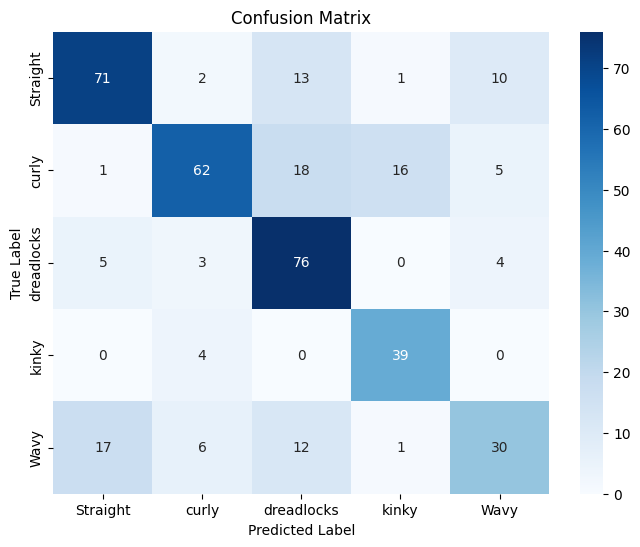

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Generate Predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get softmax outputs
    preds = np.argmax(preds, axis=1)  # Convert to class indices

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Step 2: Print Classification Report
class_report = classification_report(y_true, y_pred, target_names=classes)
print("📊 Classification Report:\n", class_report)

# Step 3: Compute & Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


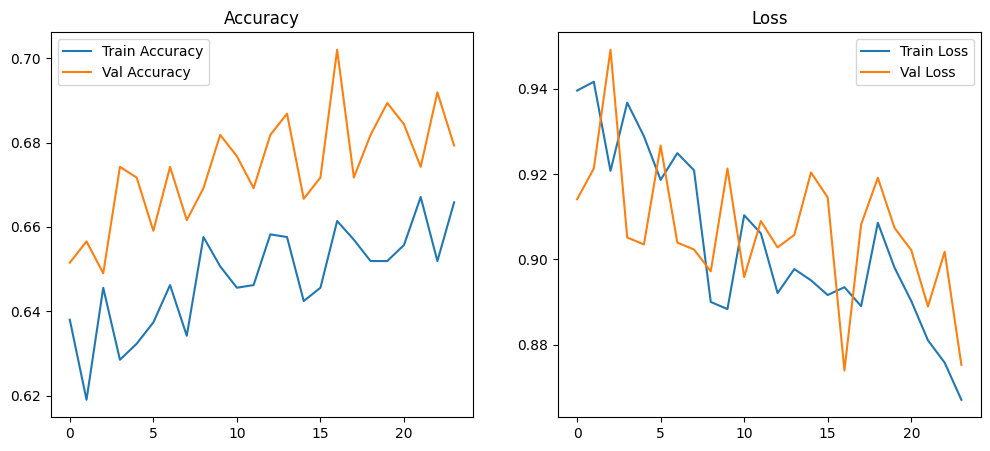

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()
